In [7]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from Network_models import HD_cell, GD_cell, traj, circle_period
from scipy.signal import find_peaks
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
from scipy.ndimage import gaussian_filter1d

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

bm.set_dt(1.)
num_hd = 100
noise_stre = 0.1
v0 = 1.0*bm.pi/1000 #baseline speed
offset_len = 1/9
Animal_speed = 1.0*v0 #vary this to change the speed of the animal


num_hd = 100
noise_stre = 0.1
v0 = 1.0*bm.pi/1000 #baseline speed
offset_len = 1/9
Animal_speed = v0*0.01 #vary this to change the speed of the animal
A = 1. #1.6
mbar_gc = 20. 
mabr_hd = 12.

alpha_hd = 0.4
alpha_gc = 0.6

theta_modulation_stre_hd = alpha_hd * 1/v0 * Animal_speed
theta_modulation_stre_gc = alpha_gc * 1/v0 * Animal_speed

N = 4
# numT = int(N*np.pi/(bm.dt*Animal_speed))
numT = 4000

Grid_net = GD_cell(
    A = A, # 3
    a = 0.8,
    k = 1.0,
    tau = 10.,
    tau_v = 100.,
    mbar = mbar_gc,
    noise_stre = noise_stre,
    num_hd = num_hd,
)
HD_net = HD_cell(num=num_hd, 
                noise_stre = noise_stre/10, #gc has muhc more neurons than hd, 10000 vs 100
                tau=10., tau_v=100., 
                k=1., mbar=mabr_hd, a=0.4, A=3., J0=4., 
                z_min=-bm.pi, z_max=bm.pi)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Moving_speed):  # 20 x size

    T_theta = 100
    #calculate TheataModulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi+np.pi/2)
    ThetaModulator_GC = 1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi+np.pi/2)
    #calculate ThetaShutdown at time step i (whether to shut down the newtork activity or not)
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center #center of mass of internal direction
    HD_activity = HD_net.r 
    #update the grid cell network \
    Phase_Offset = offset_len
    Grid_net.step_run(i, Animal_location, HD_activity, ThetaModulator_GC, Phase_Offset, Head_direction)
    
    #get results
    GC_bumpcenter = Grid_net.center
    center_grid_input = Grid_net.center_conjG
    GC_bumpactivity = Grid_net.r
    return GC_bumpcenter, Internal_direction, center_grid_input, GC_bumpactivity, HD_activity, ThetaModulator_GC


# run network

time_steps = np.arange(numT)

x = traj(x0=0, v=Animal_speed, T=numT)
Animal_location = bm.array([x, x]).transpose()
Head_direction = bm.pi/4*bm.ones(numT) #fixed head direction, mimicking the animal running in a straight line
Moving_speed = Animal_speed*bm.ones([numT,1])
#ThetaModulator = bm.ones(numT)+0.3*bm.sin(time_steps*2*bm.pi/100)
#ThetaShutdown = bm.zeros(numT)

center_grid, center_HD, center_grid_input, r_grid, r_HD, ThetaModulator_GC = bm.for_loop(
    run_CoupleNet, (time_steps, Animal_location, Head_direction, Moving_speed), progress_bar=True
    )


  0%|          | 0/4000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'bump x offset')

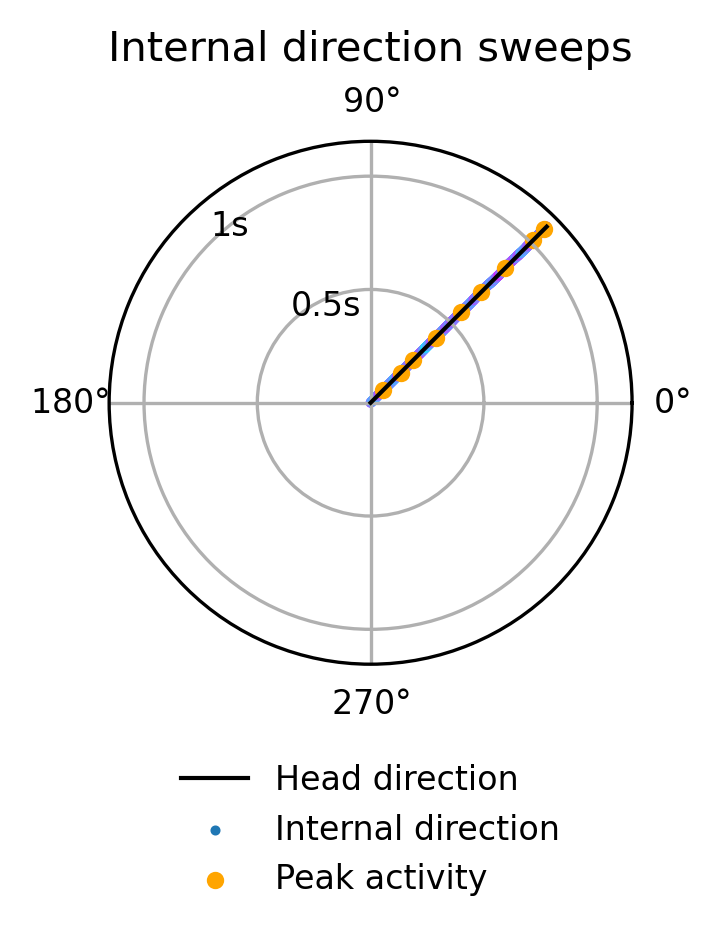

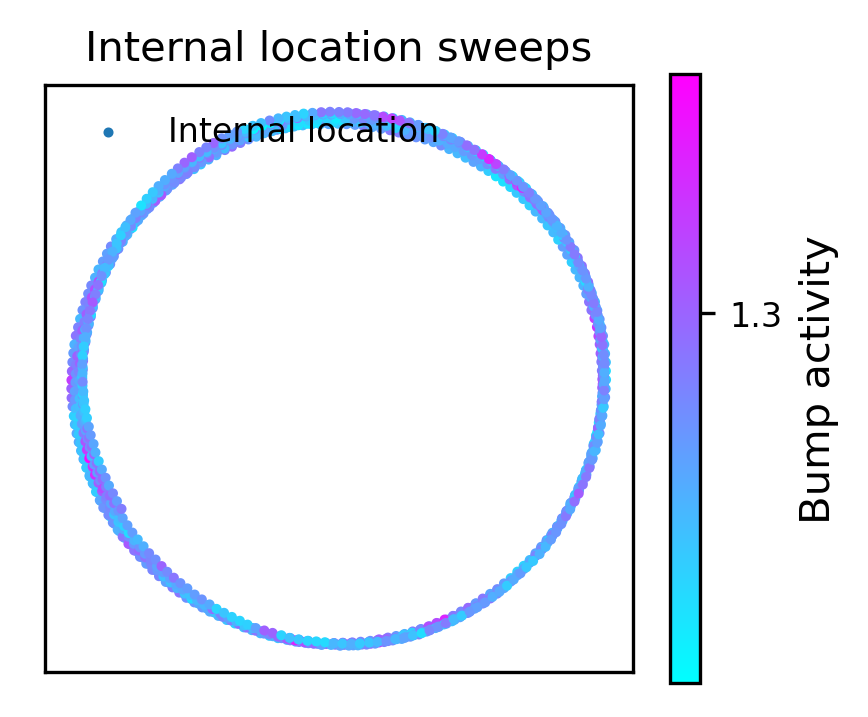

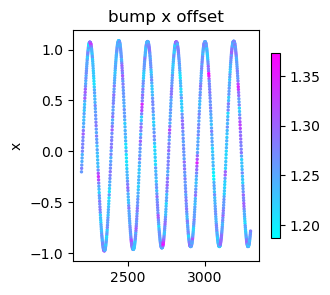

In [9]:
onecycleT = numT/(N/2)
start = int(numT - 0.9*onecycleT)
end = int(numT - 0.35*onecycleT)

max_r_grid = np.max(r_grid, axis=1)
max_bump_activity = np.max(r_HD, axis=1)

#plot internal direction and head direction in polar plot 1

fig,ax = plt.subplots(1, 1, figsize=(2.5, 3), dpi=300, subplot_kw={'projection': 'polar'})

labelsize = 10
ticksize = 8

s_size = 2

y = (time_steps[start:end]-time_steps[start])/1000

x = center_HD[start:end]
cb = ax.scatter(x,
                y,
                c=max_bump_activity[start:end], 
                cmap='cool', s=s_size, label='Internal direction')

#add peak of the activity as a orange dot to indicate the peak of the activity using pks_hdfr
max_fr = gaussian_filter1d(max_bump_activity[start:end], sigma=20) #sigma=30 more smooth to remove more than two peaks in a cycle
pks_hdfr, _ = find_peaks(max_fr)
ax.scatter(x[pks_hdfr], y[pks_hdfr], color='orange', s=10, label='Peak activity')
    

x = Head_direction[start:end]
ax.plot(x, y, linewidth=1, color='black', label='Head direction')

ax.legend(loc='lower center', fontsize=ticksize, bbox_to_anchor=(0.5, -0.5), frameon=False, ncol=1)

#xticks with 0 at east, 90 at north, 180 at west, 270 at south
ax.set_theta_zero_location("E")
#clockwise
ax.set_theta_direction(1)
#four x ticks
ax.set_xticks([0, bm.pi/2, bm.pi, 3*bm.pi/2])
ax.set_xticklabels([r'$0\degree$', r'$90\degree$', r'$180\degree$', r'$270\degree$'], fontsize=ticksize)
#yticks 
ax.set_yticks([0.5, 1])
ax.set_yticklabels(['0.5s','1s'], fontsize=ticksize)
#make yticks pointing to left top
#set direction of rlabel, and offset it a bit
ax.set_rlabel_position(135)
# Shift the rlabels down a bit
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    label.set_y(-0.5)
ax.tick_params(axis='x', pad=-1)
#r grid off
ax.grid(True)
ax.set_title('Internal direction sweeps', fontsize=labelsize)

plt.tight_layout()
plt.savefig('./figures_cyclic/HD_sweeps.pdf', dpi=300)
############################################################################################################

fig,ax = plt.subplots(1, 1, figsize=(3, 3.2), dpi=300)

sc = ax.scatter(
                center_grid[start:end, 0],
                center_grid[start:end, 1],
                c=max_r_grid[start:end],
                cmap="cool",
                s=s_size,
                label='Internal location'
)

#activity colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.7)
#xlabels on cbar
cbar.set_label('Bump activity')
cbar.set_ticks([np.round(1.1*np.min(max_r_grid),1), np.round(0.9*np.max(max_r_grid),1)])
cbar.ax.tick_params(labelsize=ticksize)


#legend
ax.legend(loc='upper left', fontsize=ticksize, frameon=False)

#ticks off
ax.set_xticks([])
ax.set_yticks([])
#make it square
ax.set_aspect('equal')

# ax.set_title('GC bump')
# Add horizontal colorbar
# cbar_ax = fig.add_axes([0.1, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
# norm = mcolors.Normalize(vmin=0, vmax=(end-start)/1000)
# cbar = mcolorbar.ColorbarBase(cbar_ax, cmap='gray', norm=norm, orientation='horizontal')
# cbar.set_label('Time (s)', fontsize=ticksize, labelpad=-5)
#ticks as 0, 1000
# cbar.set_ticks([0, 1])
# cbar.ax.tick_params(labelsize=ticksize)
ax.set_title('Internal location sweeps', fontsize=labelsize)

plt.tight_layout()

plt.savefig('./figures_cyclic/GC_sweeps.pdf', dpi=300)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)

ax.set_ylabel("x")
sc = ax.scatter(
                time_steps[start:end],
                center_grid[start:end, 0],
                c=max_r_grid[start:end],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump x offset')

